### Import

In [61]:
seed = 17
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from scipy import stats
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import pickle

### Load Data

In [62]:
# LOAD DATA
# Lists of observations and targets
Xs = []
ys = []

Xs.append(pd.read_csv("../data/credit_X.csv"))
Xs.append(pd.read_csv("../data/raisin_X.csv"))
Xs.append(pd.read_csv("../data/alzheimer_X.csv"))
Xs.append(pd.read_csv("../data/salary_X.csv"))

ys.append(pd.read_csv("../data/credit_y.csv").iloc[:, 0])
ys.append(pd.read_csv("../data/raisin_y.csv").iloc[:, 0])
ys.append(pd.read_csv("../data/alzheimer_y.csv").iloc[:, 0])
ys.append(pd.read_csv("../data/salary_y.csv").iloc[:, 0])

### Functions

In [70]:
def tune_with_random_search(model, search_grid, n_iter, scoring):
    opt_results = []
    for i in range(4):
        # in my case works faster with n_jobs=-1
        opt = RandomizedSearchCV(model, search_grid, n_iter=n_iter, cv=5, scoring=scoring, random_state=seed, n_jobs=-1)
        opt_results.append(opt.fit(Xs[i], ys[i]))
    return opt_results

def tune_with_bayes_search(model, search_grid, n_iter, scoring):
    opt_results = []
    for i in range(4):
        opt = BayesSearchCV(model, search_grid, n_iter=n_iter, cv=5, scoring=scoring, random_state=seed)
        opt_results.append(opt.fit(Xs[i], ys[i]))
    return opt_results

def get_tunability(model_class, default_grid, tuned_grids, scoring):
    tunabilities = []
    for i in range(4):
        # Replace key "model__hiperparameter" to key "hiperparameter"
        cleaned_params = {key.replace('knn__', ''): value for key, value in tuned_grids[i].best_params_.items()}
        pipe_default = Pipeline(steps=[
            ("preprocessing", MinMaxScaler()),
            ("model", model_class(**default_grid))
        ])
        pipe_tuned = Pipeline(steps=[
            ("preprocessing", MinMaxScaler()),
            ("model", model_class(**cleaned_params))
        ])

        default_score = cross_val_score(pipe_default, Xs[i], ys[i], cv=5, scoring=scoring, n_jobs=-1).mean()
        tuned_score = cross_val_score(pipe_tuned, Xs[i], ys[i], cv=5, scoring=scoring, n_jobs=-1).mean()
        tunabilities.append(tuned_score - default_score)
    return tunabilities

def save_result(result, path_to_save):
    with open(path_to_save, 'wb') as file:
        pickle.dump(result, file)

def load_result(path):
    with open(path, 'rb') as file:
        return pickle.load(file)

### KNN with MinMaxScaler

In [71]:
random_seed = 17
pipe_knn = Pipeline(
    [
        ('scaler', MinMaxScaler()),
        ('knn', KNeighborsClassifier())
    ]

)

search_grid = {
    'knn__n_neighbors': [i for i in range(1, 100)],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [i for i in range(1,4)], 
    'knn__leaf_size': [i for i in range(10, 51, 2)], 
    'knn__n_jobs': [-1],
    'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

In [72]:
%%time

knn_opt_results_rs = tune_with_random_search(pipe_knn, search_grid,100, 'roc_auc')

CPU times: user 748 ms, sys: 319 ms, total: 1.07 s
Wall time: 14.5 s


In [82]:
save_result(knn_opt_results_rs,'./saved_results/knn_opt_results_rs.pkl')

In [ ]:
#knn_opt_results_rs=load_result('./saved_results/knn_opt_results_rs.pkl')

In [74]:
for i in range(4):
    print(knn_opt_results_rs[i].best_params_)

{'knn__weights': 'uniform', 'knn__p': 1, 'knn__n_neighbors': 97, 'knn__n_jobs': -1, 'knn__leaf_size': 24, 'knn__algorithm': 'kd_tree'}
{'knn__weights': 'uniform', 'knn__p': 1, 'knn__n_neighbors': 27, 'knn__n_jobs': -1, 'knn__leaf_size': 30, 'knn__algorithm': 'kd_tree'}
{'knn__weights': 'distance', 'knn__p': 1, 'knn__n_neighbors': 94, 'knn__n_jobs': -1, 'knn__leaf_size': 18, 'knn__algorithm': 'ball_tree'}
{'knn__weights': 'distance', 'knn__p': 1, 'knn__n_neighbors': 66, 'knn__n_jobs': -1, 'knn__leaf_size': 32, 'knn__algorithm': 'kd_tree'}


In [75]:
knn_tunabilities_rs = get_tunability(KNeighborsClassifier, {'n_jobs': -1}, knn_opt_results_rs, 'roc_auc')
knn_tunabilities_rs

[0.05695101225528865,
 0.02934567901234575,
 0.15364198380987393,
 0.03940332675352021]

### Bayes

In [76]:
pipe_knn = Pipeline(
    [
        ('scaler', MinMaxScaler()),
        ('knn', KNeighborsClassifier())
    ]

)

search_grid = {
    'knn__n_neighbors': [i for i in range(1, 100)],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [i for i in range(1,4)],
    'knn__leaf_size': [i for i in range(10, 51, 2)],
    'knn__n_jobs': [-1],
    'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

In [77]:
%%time

knn_opt_results_bs = tune_with_bayes_search(pipe_knn, search_grid, 100, "roc_auc")

CPU times: user 6h 44s, sys: 3h 28min 29s, total: 9h 29min 14s
Wall time: 1h 57min 33s


In [83]:
save_result(knn_opt_results_bs,'./saved_results/knn_opt_results_bs.pkl')

In [ ]:
#knn_opt_results_bs=load_result('./saved_results/knn_opt_results_bs.pkl')

In [78]:
for i in range(4):
    print(knn_opt_results_bs[i].best_params_)

OrderedDict([('knn__algorithm', 'brute'), ('knn__leaf_size', 48), ('knn__n_jobs', -1), ('knn__n_neighbors', 93), ('knn__p', 1), ('knn__weights', 'uniform')])
OrderedDict([('knn__algorithm', 'auto'), ('knn__leaf_size', 32), ('knn__n_jobs', -1), ('knn__n_neighbors', 34), ('knn__p', 1), ('knn__weights', 'distance')])
OrderedDict([('knn__algorithm', 'kd_tree'), ('knn__leaf_size', 46), ('knn__n_jobs', -1), ('knn__n_neighbors', 98), ('knn__p', 1), ('knn__weights', 'distance')])
OrderedDict([('knn__algorithm', 'kd_tree'), ('knn__leaf_size', 38), ('knn__n_jobs', -1), ('knn__n_neighbors', 66), ('knn__p', 1), ('knn__weights', 'distance')])


In [79]:
knn_tunabilities_bs = get_tunability(KNeighborsClassifier, {'n_jobs': -1}, knn_opt_results_bs, 'roc_auc')
knn_tunabilities_bs

[0.054922037940130175,
 0.028851851851851906,
 0.15439483013627087,
 0.03940332675352021]

### Plots

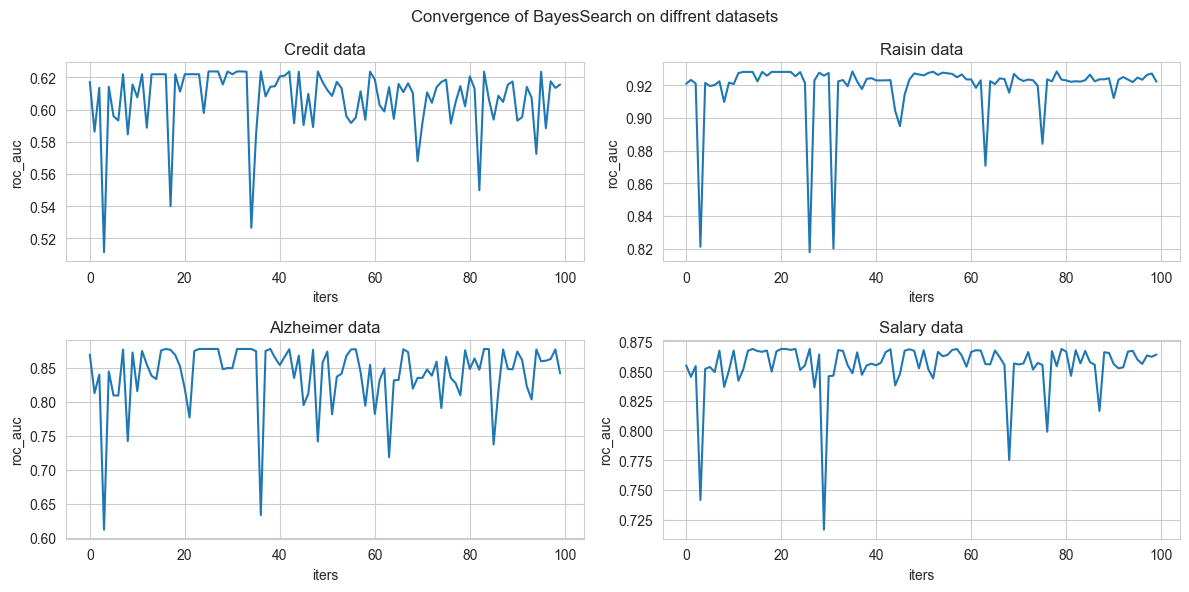

In [80]:
titles = ["Credit data", "Raisin data", "Alzheimer data", "Salary data"]
fig, axs = plt.subplots(2, 2, figsize = (12, 6))
axs = axs.flatten()
fig.suptitle("Convergence of BayesSearch on diffrent datasets")
for i in range(4):
    axs[i].plot(knn_opt_results_bs[i].cv_results_["mean_test_score"])
    axs[i].set_title(titles[i])
    axs[i].set_xlabel("iters")
    axs[i].set_ylabel("roc_auc")
plt.tight_layout()
plt.show()

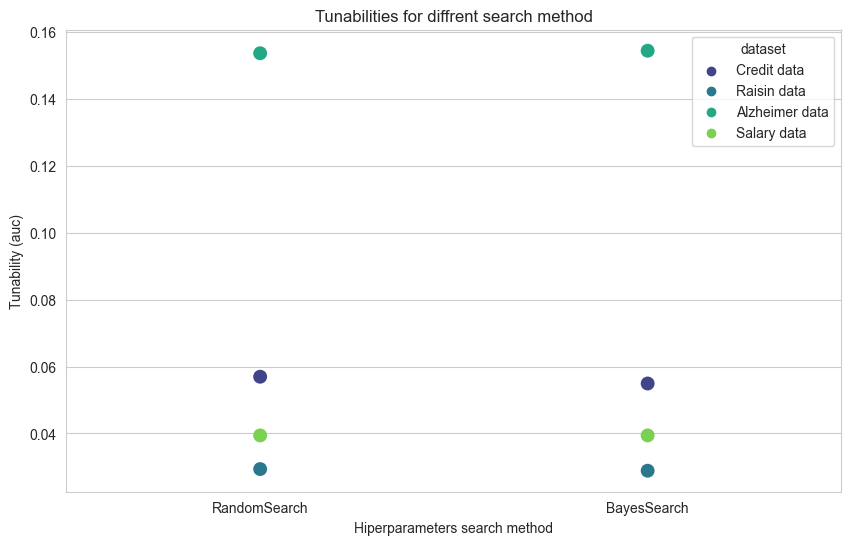

In [81]:
data = {
    'tunability': knn_tunabilities_rs + knn_tunabilities_bs,
    'alg': ["RandomSearch"] *  4 + ["BayesSearch"] * 4,
    'dataset': ["Credit data", "Raisin data", "Alzheimer data", "Salary data"]*2
}
df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.swarmplot(x='alg', y='tunability', hue='dataset', data=df, palette='viridis', size=10)

plt.title('Tunabilities for diffrent search method')
plt.xlabel('Hiperparameters search method')
plt.ylabel('Tunability (auc)')
plt.show()